In [1]:
# who's ready to code??
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
# Define the RV model which is a sine wave w/ fixed period for WASP12b
def rv_model(t, gamma, K, phase):
    P = 1.09142  # days
    return gamma + K * np.sin(2 * np.pi * (t - t[0]) / P + phase)

col_names = ["HJD", "RV", "RV_err"]
data = pd.read_csv("UID_0300068_RVC_002.tbl.txt", 
                       delim_whitespace=True, skiprows=21, names=col_names)

In [3]:
# t0 is the min value in the HJD column. We use this to put the entire column into scale

# now we call data[time] the data column minus the min value to show deviation from the time we call 0. 

# t0 is just the beginning of the cycle we're looking at

t0 = data["HJD"].min()
data["time"] = data["HJD"] - t0  # now time starts at 0

# only wanna focus on the first 100 days after observation so this 
# lets us only look at data less than or equal to 100 days

# also this creates a copy of the original set of data into a new subset for data

data = data[data["time"] <= 100].copy()

In [4]:
# mean of RV is systemic velocity, or the vel of star w.o influence ( basically its motion rel. to us)

# take guess of 200 for K and 0 for phase offset, basically lets us control the sine wave's starting point

initial_guess = [data["RV"].mean(), 200, 0]

# curve_fit let's us fit the parameters of the rv model to match the observed data

# call shifted time values from before the x axis and the rv measurements the y axis

# RV_err gives uncertainties given in the data

# p0 is the initial starting parameters from the initial guess

# popt is the optimized parameters for gamma, K, and phase of sinwave

# pcov is the covariance matrix 
# this contains the uncertainties for each of these parameters

popt, pcov = curve_fit(
rv_model, 
data["time"],  
data["RV"], 
sigma=data["RV_err"], 
p0=initial_guess,
absolute_sigma=True)

# here we can unpack the optimized parameters from the popt into individual variables

# gamma fit is the fitted systemic velocity

# K fit is the fitted semi ampl. of RV variation

gamma_fit, K_fit, phase_fit = popt

# I kept having an issue with planet mass resulting as negative so obviously there was an issue there

# I figured since K can be both positive and negative (i.e. ampl. above 0 or below 0) I should define 

# --> K as positive with this if statement keeping K positive

if K_fit < 0:
     K_fit = -K_fit
phase_fit += np.pi

# This takes the uncertainties for each of the parameters

# in the covariance matrix the diagonal figures are the variance for each parameter

# sqrt of this gives stndard error for each parameter

gamma_err, K_err, phase_err = np.sqrt(np.diag(pcov))

# this makes an array of 1000 even spaced time values from 0 to max 
# this is to create a smoother curve when plotting the model (this was very helpful when I was struggling with the model)
t_fit = np.linspace(0, data["time"].max(), 1000)

# calculate model RV at each time in t fit with the optimal parameters

# this lets me overlay fitted model on the data plot

rv_fit = rv_model(t_fit, gamma_fit, K_fit, phase_fit)

In [5]:
# this cell here is very important for the RV graph 


# Our data for WASP was clustered close to observation and didn't really
# provide great opportunity to match a model, so I used the method we discussed in class on tuesday
# considering uncertainty I used the following to simulate data points within boundaries of uncertainty to 
# extend data points and match a sin model

# this line creates an array of 50 even spaced time points from 0 to 10 days. 10 days is what I was shooting for on the graph
synthetic_times = np.linspace(0, 10, 50)

# this uses the rv model defined before with the best fit parameters to find synthetic "true" RV values at each synthetic time point
model_rv = rv_model(synthetic_times, gamma_fit, K_fit, phase_fit)

# this finds an accurate uncertainty by taking a median of the RV errors from data. This is to simulate realistic noise/varying conditions leading to error
typical_sigma = np.median(data["RV_err"])


# set the random seed so consistently we see the same random noise generated
# the goal here is to ensure reproducibility and not total randomness
np.random.seed(42) 

# add additional random noise (gaussian noise with mean 0 and std dev equal to typical sigma)
# to model RV values to create synthetic measurements mimicing real data
synthetic_rv = model_rv + np.random.normal(loc=0.0, scale=typical_sigma, size=len(model_rv))


#finally this one makes an array of the same shape as synth RV where every element set to typic sigma
# this is to represent sim. uncertainty at each synthetic data point
synthetic_err = np.full_like(synthetic_rv, typical_sigma)

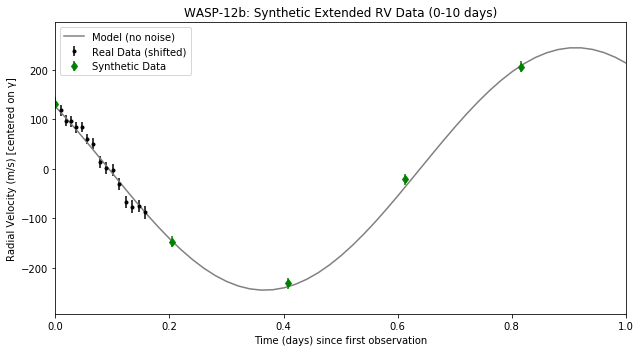

In [6]:
# this graph focuses on just around 1 day after observation to show observation's consistency with the model
plt.figure(figsize=(9, 5))

# this plots the actual RV data while subtracting the systemic vel. so we can center it around 0

plt.errorbar(data["time"], data["RV"] - gamma_fit,
                yerr=data["RV_err"], fmt='k.', label="Real Data (shifted)")

# this overlays the synthetic data simulated by considering uncertainties to match the model

plt.errorbar(synthetic_times, synthetic_rv - gamma_fit,
                yerr=synthetic_err, fmt='gd', label="Synthetic Data")

# takes the time array from 0 to 10 days with 500 points

fine_t = np.linspace(0, 10, 500)

# takes the fitted rv model at these times with the best fit parameters

fine_rv = rv_model(fine_t, gamma_fit, K_fit, phase_fit)

# plot this noise free model with the gray line 

plt.plot(fine_t, fine_rv - gamma_fit, color='gray', label="Model (no noise)")

plt.xlabel("Time (days) since first observation")
plt.xlim(0,1)
plt.ylabel("Radial Velocity (m/s) [centered on γ]")
plt.title("WASP-12b: Synthetic Extended RV Data (0-10 days)")
plt.legend()
plt.tight_layout()
plt.savefig("WASP12b_synthetic_0to10days.png")
plt.show()

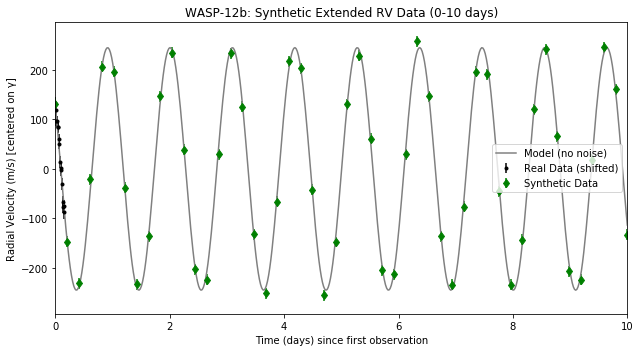

In [7]:
# this graph extends the model to about 10 days since observation with the simulated data

# overall this effort is to combat the limited data points in the RV file

# maybe WASP 12 b wasn't the easiest choice

plt.figure(figsize=(9, 5))


plt.errorbar(data["time"], data["RV"] - gamma_fit,
                yerr=data["RV_err"], fmt='k.', label="Real Data (shifted)")

plt.errorbar(synthetic_times, synthetic_rv - gamma_fit,
                yerr=synthetic_err, fmt='gd', label="Synthetic Data")

fine_t = np.linspace(0, 10, 500)
fine_rv = rv_model(fine_t, gamma_fit, K_fit, phase_fit)
plt.plot(fine_t, fine_rv - gamma_fit, color='gray', label="Model (no noise)")

    # Set axis labels and title
plt.xlabel("Time (days) since first observation")
plt.xlim(0,10)
plt.ylabel("Radial Velocity (m/s) [centered on γ]")
plt.title("WASP-12b: Synthetic Extended RV Data (0-10 days)")
plt.legend()
plt.tight_layout()
plt.savefig("WASP12b_synthetic_0to10days.png")
plt.show()

In [8]:
# print the best fit value for systemic velocity (gamma) with uncertainty

print(f"Fitted gamma: {gamma_fit:.2f} ± {gamma_err:.2f} m/s")

# print best fit value for RV semi-amplitude (K) with uncertainty
# reminder: K is what represents how the star's velocity changes due to the planet

print(f"Fitted K:     {K_fit:.2f} ± {K_err:.2f} m/s")

# print best-fit phase offset to find the sine wave's starting point again with uncertainty

print(f"Fitted phase: {phase_fit:.2f} ± {phase_err:.2f} rad")

Fitted gamma: 19084.02 ± 1.74 m/s
Fitted K:     245.21 ± 4.50 m/s
Fitted phase: 2.60 ± 0.01 rad


In [9]:
# Now compute the planet mass from the fitted semi-amplitude K.
# For a circular orbit:
# K = (2πG/P)^(1/3) * (M_p * sin i) / (M_star)^(2/3)
# => M_p = K * (M_star^(2/3)) * (P/(2πG))^(1/3) / sin i
# For transiting WASP‑12b, sin i ≃ 1.


G = 6.67430e-11         # Gravitational constant (SI units)
M_sun = 1.98847e30        # Solar mass in kg
M_star = 1.35 * M_sun     # Estimated stellar mass for WASP‑12
P_days = 1.09142          # Orbital period in days
P_sec = P_days * 86400    # Convert period to seconds

# formula taken from class and cross referenced (deriving M_p from K formula)
M_p = K_fit * (M_star**(2/3)) * ((P_sec/(2 * np.pi * G))**(1/3))
# Propagate the uncertainty from K only (assuming other parameters are known exactly)
M_p_err = K_err * (M_star**(2/3)) * ((P_sec/(2 * np.pi * G))**(1/3))

# Convert planet mass to Jupiter masses.
M_jup = 1.89813e27       # Jupiter mass in kg
M_p_jup = M_p / M_jup
M_p_err_jup = M_p_err / M_jup

# planet mass to two decimal places along with uncertainty
# both in kg and Jupiter masses
print("Derived planet mass:")
print(f"  M_p = {M_p:.2e} ± {M_p_err:.2e} kg")
print(f"  = {M_p_jup:.2f} ± {M_p_err_jup:.2f} Jupiter masses")

# actual value is appx 1.47 Jupiter masses, so just about within the uncertainty

Derived planet mass:
  M_p = 2.88e+27 ± 5.29e+25 kg
  = 1.52 ± 0.03 Jupiter masses


In [10]:
# time for transit data! this is just to read in the file and skip over the annoying stuff at the beginning

col_names = ["HJD", "diff_mag", "diff_mag_err", "accepted"]
data = pd.read_csv(
    "UID_0300068_PLC_001.tbl.txt",
    delim_whitespace=True,
    skiprows=143,   
    names=col_names
)

In [11]:
# once again this is to create a new data subset with values equaling 1

data = data[data["accepted"] == 1].copy()

In [12]:
# Convert differential magnitude to flux:
#    formula is flux = 10^(-0.4 * diff_mag)
# so that diff_mag = 0 => flux ~ 1
data["flux"] = 10**(-0.4 * data["diff_mag"])

In [13]:
# Propagate error in diff_mag to flux error
#   If F = 10^(-0.4*m), then dF = F * ln(10)*(-0.4) * dm
ln10 = 2.302585093
data["flux_err"] = data["flux"] * ln10 * (-0.4) * data["diff_mag_err"]

In [14]:
# Orbital parameters given:
P = 1.091047
Tmid = 2454023.3311

# Compute phase in [0,1)
data["phase"] = ((data["HJD"] - Tmid) / P) % 1.0

# Shift so that the transit center is at phase ~ 0
data["phase_centered"] = data["phase"].apply(lambda ph: ph if ph < 0.5 else ph - 1.0)

In [15]:
# define the box model to overlay the data points to show dip in flux

def box_transit_model(phase_array, depth=0.015, width=0.03):
    flux = np.ones_like(phase_array)
    in_transit = (np.abs(phase_array) < width/2)
    flux[in_transit] = 1.0 - depth
    return flux

In [1]:
plt.figure(figsize=(8,5))

# Sort by phase_centered so the line plot doesn't jump
data_sorted = data.sort_values("phase_centered")

# Plot flux vs. phase
plt.errorbar(data_sorted["phase_centered"],
             data_sorted["flux"],
             yerr=data_sorted["flux_err"],
             fmt='o',
             ms=3,
             alpha=0.5,
             color='black',
             ecolor='gray',
             label="Data")

# Create a fine phase grid around +/-0.2 
phase_grid = np.linspace(-0.2, 0.2, 200)

# Evaluate the box transit model
model_flux = box_transit_model(phase_grid, depth=0.02, width=0.1)

# Plot the model
 plt.plot(phase_grid, model_flux, 'r-', linewidth=3, label='Transit model')

plt.xlabel("Phase (centered at transit)")
plt.xlim(-0.15,0.15)
plt.ylim(0.92,1.08)
plt.ylabel("Relative Flux")
plt.title("WASP-12b Transit Light Curve")
plt.legend()
plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

In [17]:
# Define "in-transit" vs. "out-of-transit" by some phase cut

# this is where I can show some actual numbers to show change in flux during / out of transit

# this is called a Boolean mask it basically says true or false for each data point and selects the one where absolute phase is < .02
# as well as the other one where the absolute phase is > 1 to show points that are far out of transit

in_mask  = (data["phase_centered"].abs() < 0.02)
oot_mask = (data["phase_centered"].abs() > 0.1)

# uses those boolean masks for in/out transit to find the median value for flux at both instances
F_in  = data.loc[in_mask, "flux"].median()
F_oot = data.loc[oot_mask, "flux"].median()


# finds difference between the flux when out of transit and when in transit to show how much light is blocked by WASP12b
transit_depth = F_oot - F_in
Rp_Rs = np.sqrt(transit_depth)

# show me all dat

print(f"Out-of-transit flux ~ {F_oot:.5f}")
print(f"In-transit flux     ~ {F_in:.5f}")
print(f"Transit depth       ~ {transit_depth:.5f}")
print(f"Estimated R_p/R_s   ~ {Rp_Rs:.4f}")

Out-of-transit flux ~ 1.00082
In-transit flux     ~ 0.98629
Transit depth       ~ 0.01453
Estimated R_p/R_s   ~ 0.1206


In [18]:
# count how many data points are in that in transit region / how many aren't
n_in = len(data.loc[in_mask, "flux"])
n_oot = len(data.loc[oot_mask, "flux"])

# finds the standard error of flux in both instances
# standard deviation of flux values are divided by sqrt of # of data points within the given region (either in or out of transit)
sigma_in = np.std(data.loc[in_mask, "flux"]) / np.sqrt(n_in)
sigma_oot = np.std(data.loc[oot_mask, "flux"]) / np.sqrt(n_oot)

# transit depth is the difference b/w out of transit and in transit flux
# this propagates the uncertainties for both the regions using standard formula for combining errors
sigma_depth = np.sqrt(sigma_oot**2 + sigma_in**2)

# talked about this in class... planet to star ratio is Rp/Rs = sqrt(transit_depth) 
# we can propagate the error through a sqrt operation
sigma_Rp_Rs = (0.5 / np.sqrt(transit_depth)) * sigma_depth


# print me some values thank ya very much
print(f"Transit depth uncertainty = {sigma_depth:.5f}")
print(f"Rp/Rs uncertainty = {sigma_Rp_Rs:.4f}")

# simple definition of the radius of WASP-12 (the star)
R_star_solar = 1.6       
R_sun = 6.957e8          
R_star_m = R_star_solar * R_sun

# this is planetary radius which is found by multiplying the ratio Rp/Rs by Rs (obviously)
# uncertainty in Rp is scaled by star radius shown here
R_p_m = Rp_Rs * R_star_m
sigma_R_p_m = R_star_m * sigma_Rp_Rs

#convert the planet radius from meters to jupiter radii 
R_jup = 7.1492e7         
R_p_jup = R_p_m / R_jup
sigma_R_p_jup = sigma_R_p_m / R_jup


# here is the good stuff
print(f"Estimated planetary radius = {R_p_m:.2e} m ± {sigma_R_p_m:.2e} m")
print(f"Estimated planetary radius = {R_p_jup:.2f} R_J ± {sigma_R_p_jup:.2f} R_J")

Transit depth uncertainty = 0.00141
Rp/Rs uncertainty = 0.0059
Estimated planetary radius = 1.34e+08 m ± 6.52e+06 m
Estimated planetary radius = 1.88 R_J ± 0.09 R_J


In [19]:
from math import pi, sqrt

# find density with known formula when given Rp and Mp. Easy peasy

density = M_p / ((4.0/3.0) * pi * (R_p_m ** 3))

# once again we gotta propagate the uncertainties from before into this uncertainty
# note that 3 * radius uncertainty since volume is prop. to R^3. 
sigma_density = density * sqrt((M_p_err / M_p) ** 2 + (3 * sigma_R_p_m / R_p_m) ** 2)

# we got our density in g/cm^3 but let's convert to kg/m^3 cuz standard/typical SI units that's why. 
density_gcm3 = density / 1000.0
sigma_density_gcm3 = sigma_density / 1000.0

# low ahh density
# this is relatively consistent with actual value tho so dance !
print(f"Planet density = {density:.2f} kg/m³ ± {sigma_density:.2f} kg/m³")
print(f"Planet density = {density_gcm3:.2f} g/cm³ ± {sigma_density_gcm3:.2f} g/cm³")

Planet density = 284.58 kg/m³ ± 41.83 kg/m³
Planet density = 0.28 g/cm³ ± 0.04 g/cm³


In [20]:
# thank you and good night